In [1]:
cd e:/BNUCloud/work/git/Scripts/snr14/

e:\BNUCloud\work\git\Scripts\snr14


In [33]:
import _pickle
import emcee
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from matplotlib import path
from scipy.special import erf
from scipy import stats
import numpy.ma as ma
from pandas import  Series, DataFrame
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib

In [26]:
def datainborder(name, points = None, cloudn = None):
    """to judge which points are located in the cloud border we choose, then get their data
    Args:
        name: name of target SNR, eg.'snr169'
        points: a list of number pairs, if None, points will be loaded from file
        cloudn : number of clouds, if None, only one cloud's resources will be selected
    Return:
        data: 2-d recarray, data of stars in the selected region
    """
    if cloudn ==None:
        cloudn = 1
    if points == None:
        #load points from file
        pointsfile_path = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_points_{1}.pkl'.format(name, cloudn))
        pointsfile = open(pointsfile_path, 'rb')  
        points = _pickle.load(pointsfile)
        pointsfile.close()
    #judge which stars are located in the region
    p = path.Path(points)  #form a path object, which represent the border of the region selected 
    stardata = readsav(pjoin('..', '..', 'Data', 'extin3d', 'discalib', 'result', '{0}.sav'.format(name)), python_dict = True)
    stardata = stardata['res']
    coordinates = np.vstack(stardata.rd)[:,0:2]
    index = p.contains_points(coordinates)
    # extract data 
    data = stardata[index]
    data = data[data.ar > 0] #delete the data where ar = 0
    #save the data, so time can be saved for the next time
    datapath = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_diar_{1}.pkl'.format(name, cloudn))
    datafile = open(datapath, 'wb')
    _pickle.dump(data, datafile, 2)
    datafile.close()
    return data

In [27]:
def sigmaclips(data, start, end, length, nsigma_up, nsigma_down):
    '''sigmaclip the samples in each bin
    Args:
        data: 2-d array, [dis, ar]
        start, end, length: imformation for setup bins
        nsigma_down : float, Lower bound factor of sigma clipping.
        nsigma_up : float, Upper bound factor of sigma clipping. 
    '''
    #
    data=np.array(data)
    bin_number = int((end - start) // length)  #decide how many bins will be choosen
    arlist = []
    dislist = []
    for i in np.arange(bin_number):
        index = np.logical_and(data[0] > start + i * length, data[0] < start + (i + 1) * length)
        if np.count_nonzero(index) >= 1:
            binar = data[1][index]
            bindis = data[0][index]
            c, l, u= stats.sigmaclip(binar, nsigma_down, nsigma_up)
            ix = np.where((l <= binar) & (binar <= u))[0]
            arb = binar[ix]
            disb = bindis[ix]
        else:
            arb = []
            disb = []
        arlist.append(arb)
        dislist.append(disb)
    ar = np.concatenate(arlist)  #join a sequence of arrays along an existing axis
    dis = np.concatenate(dislist)
    ar = np.ma.compressed(ar)  #Return all the non-masked data as a 1-D array
    dis = np.ma.compressed(dis)
    return dis, ar

In [28]:
def lnlike(theta, x, y, yerr, D):
    a, b, d0, d_ar= theta
    model = a * x + b * x ** 2 + d_ar / 2.0 * (1 + erf((x - d0) / np.sqrt(2) / (D/60./360*2*np.pi)/d0))
    return np.sum(np.log(1 / (np.sqrt(2 * np.pi) * yerr)) + (-(y - model) ** 2 / (2 * yerr ** 2)))

def lnprior(theta):
    a, b, d0, d_ar= theta
    if -10 < a < 10 and -1 < b < 1 and 0 < d0 < 2 and 0 < d_ar < 3. :
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr, D):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr, D)

In [29]:
def MCMCbasic(dis, ar, ndim, nwalkers, start, end, step, p0, diameter, nsigma_down, nsigma_up):
    '''basic MCMC function used for fitting one set of data
    Args:
        dis: 1-d array, distance data
        ar: 1-d array, extinction data
        ndim: int, number of parameters that need to be fitted
        nwalkers: arguments needed by emcee. 'The number of Goodman & Weare "walkers".'
        start, end, length: imformation for setup bins, needed by sigmaclips
        p0: array-like of length 4, initial guesses for parameters
        nsigma_down : float, Lower bound factor of sigma clipping.
        nsigma_up : float, Upper bound factor of sigma clipping. 
    Returns:
        pfit: array-like of length 4, fitted parameters
        samples: samples of parameters
        lower: lowlimit of paras
        uper: uperlimit of paras
    '''
    x, y = sigmaclips(np.array([dis,ar]), start, end, step, nsigma_down, nsigma_up)
    yerr = np.zeros_like(x)
    D = np.zeros_like(x)
    yerr[:] = 0.15
    D[:] = diameter
    pos = [np.array(p0) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr, D))
    sampler.run_mcmc(pos, 2000)
    samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
    #samfig = corner.corner(samples, labels = ["$a$", "$b$", r'$\d_0\$', r'$\deltaA_r\$' ])
    results = np.percentile(samples, [16, 50, 84], axis = 0)
    pfit = results[1]
    lower = results[0] - results[1]
    uper = results[2] - results[1]
    return pfit, samples, lower, uper

In [50]:
def disarMCMCall(name, ndim = None, nwalkers = None, start = None, end = None ,step = None, p0 = None, 
                 diameter = None, nsigma_down = None, nsigma_up = None, strategy = None, N = None, cloudn = None):
    '''basic MCMC function used for fitting one set of data
    Args:
        name: name of target SNR, eg.'snr169'
        ndim: int, number of parameters that need to be fitted, default is 4
        nwalkers: arguments needed by emcee. 'The number of Goodman & Weare "walkers".' default is 100
        start, end, length: imformation for setup bins, needed by sigmaclips, default is 0.3
        p0: array-like of length 4, initial guesses for parameters, default is [0.81, -0.07, 1.2, 0.2] ,guess for IC443
        diameter: int, diameter of SNR in arcmin, default is 45
        nsigma_down : float, Lower bound factor of sigma clipping. default is 2
        nsigma_up : float, Upper bound factor of sigma clipping. default is 2
        strategy: None, "MC" or "Bootstrap", fitting strategy applied to calculate distance error, 
            Default is None, means run mcmc only once
        N: int, if run-times for strategy "Bootstrap" and "MC", Default is 100
        cloudn : number of clouds, if None, only one cloud's resources will be selected, default is 1
    Returns:
        pfit: array-like of length 4, fitted parameters
        samples: samples of parameters
        lower: lowlimit of paras
        uper: uperlimit of paras
    '''
    if ndim == None:
        ndim = 4
    if nwalkers == None:
        nwalkers = 100
    if start == None:
        start = 0.3
    if end == None:
        end = 3.0
    if step == None:
        step = 0.1
    if p0 == None:
        p0 = [0.81, -0.07, 1.2, 0.2]
    if diameter == None:
        diameter = 45
    if nsigma_down == None:
        nsigma_down = 2
    if nsigma_up == None:
        nsigma_up = 2
    if N == None:
        N = 100
    if cloudn == None:
        cloudn = 1
    #load distance and extinction data
    datapath = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_diar_{1}.pkl'.format(name, cloudn))
    datafile = open(datapath, 'rb')
    data = _pickle.load(datafile)
    dis, ar = data.dis, data.ar
    datafile.close()
    
    if strategy == 'Bootstrap':  # uncompleted!!! not useable
        paras = np.zeros((N,4))
        for i in range(N):
            ix = np.random.choice(len(dis), int(len(dis)*0.9))
            disi = dis[ix]
            ari = ar[ix]
            paras[i], _, _, _= MCMCbasic(disi, ari, ndim, nwalkers, start, end, step, p0, diameter, nsigma_down, nsigma_up)
        pfit = np.mean(paras, axis = 0)
        perror = np.std(paras, axis = 0)
    elif strategy == 'MC':
        paras = np.zeros((N,4))
        for i in range(N):
            disi = dis * (1+np.random.normal(loc=0.,scale=0.2, size=len(dis)))  #adding random errors on distance data
            ari = ar
            paras[i], _, _, _= MCMCbasic(disi, ari, ndim, nwalkers, start, end, step, p0, diameter, nsigma_down, nsigma_up)
        results = np.percentile(paras, [16, 50, 84], axis = 0)
        pfit = results[1]
        perror = (results[2]-results[0])/2
        #pfit = np.mean(paras, axis = 0)
        #perror = np.std(paras, axis = 0)
    else:
        pfit, paras, l, u = MCMCbasic(dis, ar, ndim, nwalkers, start, end, step, p0, diameter, nsigma_down, nsigma_up)
        perror = (u - l) / 2
    # plotting the result
    matplotlib.rcdefaults()
    
    x1 = np.arange(0,5,0.01)
    p = matplotlib.rcParams
    p["figure.subplot.left"] = 0.125
    p["figure.subplot.right"] = 0.95   
    p["figure.subplot.bottom"] = 0.12  
    p["figure.subplot.top"] = 0.95   
    p["figure.subplot.wspace"] = 0.05
    p["figure.subplot.hspace"] = 0.05
    fig = plt.figure(figsize=(4.5,4))
    plt.rc('text', usetex=True)
    ax = fig.add_subplot(111)
    stars = ax.plot(dis,ar,'.k', ms = 3, label = r'$\rm Sources~in~selected~area$')
    for a, b, d0, d_ar  in paras[np.random.randint(len(paras), size=100)]:
        _=ax.plot(x1, a * x1 + b * x1 ** 2 + d_ar / 2.0 * (1 + erf((x1 - d0) / np.sqrt(2) / (diameter/60./360*2*np.pi)/d0)) ,
                  color="b", alpha=0.1)
    #star_sem = ax.errorbar(x, y, yerr = yerr, fmt = '.', color = 'r', capsize = 2, zorder=10)
    #star_sem.set_label('Medians and errors')
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,4.0])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.tick_params(labelsize=12)
    xla = ax.set_xlabel(r"$\rm d~(kpc)$", fontsize=12)
    yla = ax.set_ylabel(r"$\rm A_r~(mag)$", fontsize=12)
    a, b = pfit[0], pfit[1]
    fakeline = ax.plot(x1, a * x1 + b * x1 ** 2, 'r--', label = r'$\rm A_r(d)~without~MC$')
    #ax.legend(fontsize = 13)
    #tit = ax.set_title('extinction vs distance of {0}'.format(name))
    eximg = pjoin('..', '..', 'Data', 'extin3d', 'results', 'snrext_{0}_{1}.pdf'.format(name, cloudn))
    #samimg = pjoin('..', '..', 'Data', 'extin3d', 'results', 'corner_{0}_{1}.png'.format(name))
    fig.savefig(eximg, dpi = 360, transparent = True)
    #samfig.savefig(samimg)
    plt.show()
    return pfit, perror


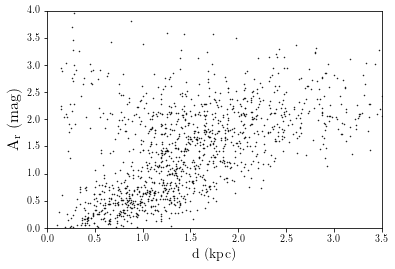

In [30]:
import _pickle
name='snr169'
datapath = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_diar.pkl'.format(name))
datafile = open(datapath, 'rb')
data = _pickle.load(datafile)
dis, ar = data.dis, data.ar
datafile.close()
fig = plt.figure()
ax = fig.add_subplot(111)
stars = ax.plot(dis,ar,'.k', label = 'Sources in selected area', ms=1)
plt.rc('text', usetex=True)
ax.set_xlim([0,3.5])
ax.set_ylim([0,4.0])
xla = ax.set_xlabel(r"$\rm d~(kpc)$", fontsize=14)
yla = ax.set_ylabel(r"$\rm A_r~(mag)$", fontsize=16)
plt.show()

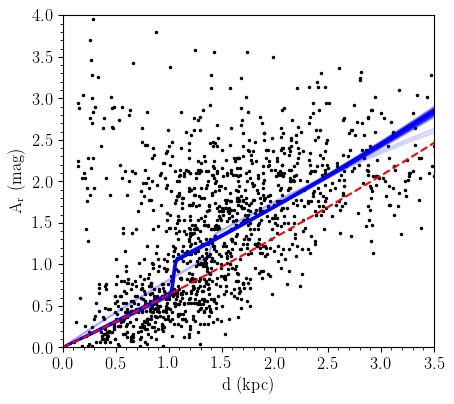

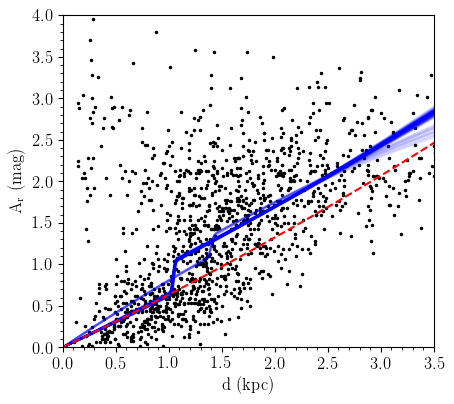

Wall time: 23.2 s


In [52]:
%%time
pfit, perror=disarMCMCall('snr169')#,strategy='MC')

In [39]:
pfit

array([ 0.85054515, -0.07207122,  1.0883303 ,  0.28247301])

In [40]:
perror

array([ 0.12887094,  0.03559115,  0.18805014,  0.10329672])

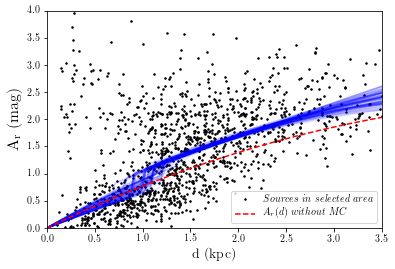

Wall time: 35min 16s


In [10]:
%%time
pfit, perror=disarMCMCall('snr169',strategy='MC',N=100)

In [11]:
pfit

array([ 0.84477341, -0.07528546,  1.09931538,  0.28776774])

In [12]:
perror

array([ 0.12453762,  0.03486872,  0.15279146,  0.10212588])

In [ ]:
name='snr169'
ndim = 4
nwalkers = 100
start = 0.3
end = 3.0 
step = 0.1
p0 = [0.81, -0.07, 1.2, 0.2]
diameter = 45
sigmanum = 2
strategy = None
N = 1000

datapath = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_diar.pkl'.format(name))
datafile = open(datapath, 'rb')
data = _pickle.load(datafile)
dis, ar = data.dis, data.ar
datafile.close()
paras = np.zeros((100,4))
for i in range(100):
    ix = np.random.choice(len(dis), len(dis)//2)
    disi = dis[ix]
    ari = ar[ix]
    x, y = sigmaclips(np.array([disi,ari]), start, end, step, sigmanum)
    print(len(x),len(y))
    #paras[i], _, _, _= MCMCbasic(disi, ari, ndim, nwalkers, start, end, step, p0, diameter, sigmanum)

In [ ]:
name='snr169'
ndim = 4
nwalkers = 100
start = 0.3
end = 3.0 
step = 0.1
p0 = [0.81, -0.07, 1.2, 0.2]
diameter = 45
sigmanum = 2
strategy = None
N = 1000

datapath = pjoin('..', '..', 'Data', 'extin3d', 'results', '{0}_diar.pkl'.format(name))
datafile = open(datapath, 'rb')
data = _pickle.load(datafile)
dis, ar = data.dis, data.ar
datafile.close()
paras = np.zeros((100,4))
ix = np.random.choice(len(dis), len(dis)//2)
disi = dis[ix]
ari = ar[ix]

In [ ]:
%%time
ccccc, _, _, _= MCMCbasic(disi, ari, ndim, nwalkers, start, end, step, p0, diameter, sigmanum)

In [ ]:
import _pickle

In [ ]:
pfit

In [ ]:
datt = daa[:,2]

plt.plot(datt)
plt.show()